# Working with MRI data in Python
There is an entire suite of Python libraries for reading, processing, and analyzing MRI data, primarily centered around the nipy ecosystem. We have more information about these libraries in the Onboarding wiki.

In [1]:
# This next line is a special Jupyter Notebook
# command (also known as a "magic") that lets
# us show figures *in* the notebook
%matplotlib inline

## Loading data

In [2]:
# nibabel is used to read/write neuroimaging data
import nibabel as nib

# nilearn.datasets lets us download/use certain public datasets
from nilearn import datasets

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [3]:
# Grab one subject's data from the ADHD200 dataset
dset = datasets.fetch_adhd(n_subjects=1)
func_file = dset.func[0]

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/nilearn/datasets/func.py:501: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  dtype=None)


In [4]:
# Load functional data from file
img = nib.load(func_file)
print(type(img))

# We can load the actual 4D data as a
# Nifti1Image with get_data
data = img.get_data()

# We can also access metadata like the
# affine
affine = img.affine
print(affine)

# Or the voxel sizes
# *Note that the last one is the TR*
voxel_sizes = img.header.get_zooms()
print(voxel_sizes)

<class 'nibabel.nifti1.Nifti1Image'>
[[  -3.   -0.   -0.   90.]
 [  -0.    3.   -0. -126.]
 [   0.    0.    3.  -72.]
 [   0.    0.    0.    1.]]
(3.0, 3.0, 3.0, 2.0)


## Visualizing data

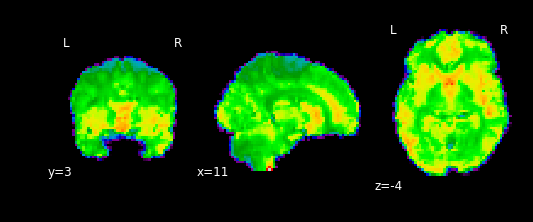

In [5]:
from nilearn.plotting import plot_epi

# First we grab the first volume from
# the image and put that in its own
# image object
# To do this, we need the array of values
# from get_data and the affine from the
# image header
img_3d = nib.Nifti1Image(img.get_data()[:, :, :, 0],
                         img.affine)
plot_epi(img_3d, draw_cross=False)

## Extracting ROIs
It is very easy to extract mean values of masked regions (i.e., ROIs) from neuroimaging data in array format using pure `numpy`, as long as the mask image and the data image have the same dimensions, orientation, resolution, etc. However, since checking that explicitly every time can be tedious, it's generally easier to use `nilearn`, which has an entire module dedicated to masking and extracting data (`nilearn.masking`).

`nilearn.masking` and `nilearn.input_data` include classes to build masks (even just from a list of coordinates!), extract data from ROIs, and even _unmask_ data (i.e., reshape values from ROIs into full brain maps). Below we go through a couple of these tools.

In [6]:
from nilearn import input_data

# The NiftiSpheresMasker builds separate masks for a
# set of spheres centered on the seeds
# You can then extract the mean value or timeseries
# (in the case of 4D images) for each one of those spheres
# The masker can perform a number of functions,
# including bandpass filtering and smoothing, but we
# have disabled those in this case, although we will
# standardize the values for our plots in the next cell
seeds = [[0, 0, 0], [20, 20, 20]]
t_r = img.header.get_zooms()[-1]
spheres_masker = input_data.NiftiSpheresMasker(
    seeds=seeds, radius=5., t_r=t_r,
    smoothing_fwhm=None, detrend=False, standardize=True,
    low_pass=None, high_pass=None)

seed_timeseries = spheres_masker.fit_transform(img)

/Users/tsalo/anaconda/envs/python3/lib/python3.6/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


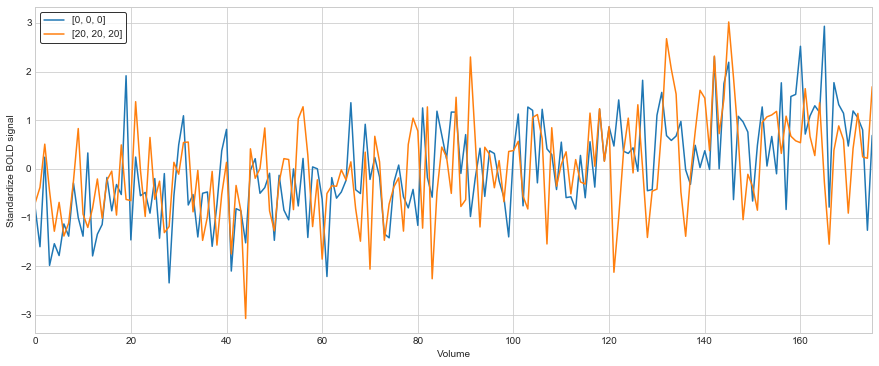

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

fig, ax = plt.subplots(figsize=(15, 6))
for i in range(len(seeds)):
    ax.plot(seed_timeseries[:, i], label=str(seeds[i]))
legend = ax.legend(frameon=True)
frame = legend.get_frame()
frame.set_facecolor('white')
frame.set_edgecolor('black')
ax.set_xlim(0, seed_timeseries.shape[0]-1)
ax.set_ylabel('Standardize BOLD signal')
ax.set_xlabel('Volume')
fig.show()